In [364]:
%matplotlib inline
import cv2
import fastai
from fastai.vision.all import *
import os
import numpy as np

In [9]:
data_dir = Path('C:\Datasets\CHESS_BOARDS\pictures')

In [439]:
fnames = get_image_files(data_dir)
fnames[:5]

(#3) [Path('C:/Datasets/CHESS_BOARDS/pictures/1.PNG'),Path('C:/Datasets/CHESS_BOARDS/pictures/2.PNG'),Path('C:/Datasets/CHESS_BOARDS/pictures/3.PNG')]

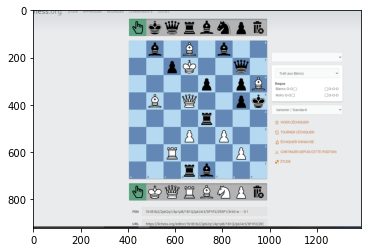

In [441]:
f = fnames[2]
img = cv2.imread(str(f))
plt.imshow(img)
plt.show()

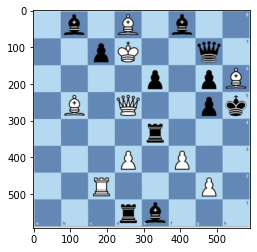

In [448]:
board = get_board(img)
plt.imshow(board)
plt.show()

In [447]:
def get_board(img):
    imgblu = cv2.GaussianBlur(img, (3, 3), 0)
    imgray = cv2.cvtColor(imgblu, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    block_size = 50
    board_size = 8 * block_size
    max_area = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > 2000:
            peri = cv2.arcLength(c, True)
            poly = cv2.approxPolyDP(c, 0.01 * peri, True)
            if len(poly) == 4 and area > max_area:
                max_area = area
                board_c = poly
    if board_c is not None:
        #cv2.drawContours(img, [board_c], 0, (0, 255, 0), 3)
        points = np.vstack(board_c).squeeze()
        board = four_point_transform(img, points)
        return board


def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped